In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms
import ignite
from ignite.engine import create_supervised_evaluator

import backdoor_attack as bd
import backdoor_attack.plot_util
import net

In [2]:
# result output folder
out = os.path.join('results', 'fine_tuned_model')
os.makedirs(os.path.join(out), exist_ok=True)

# device setup
if torch.cuda.is_available():
    device = torch.device(type='cuda', index=1)
else:
    device = torch.device(type='cpu')

## データセットの準備

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
ds_root = os.path.join('.', 'results', 'datasets')
tr = np.load(os.path.join('.', 'results', 'screening', 'screening_negative_dataset.npz'))
train_ds = bd.Dataset_from_array(x=tr['x'], t=tr['t'], transform=transform)
te = np.load(os.path.join(ds_root, 'clean_test_dataset.npz'))
test_ds = bd.Dataset_from_array(x=te['x'], t=te['t'], transform=transform)
te_p = np.load(os.path.join(ds_root, 'poison_test_dataset.npz'))
test_p_ds = bd.Dataset_from_array(x=te_p['x'], t=te_p['t_correct'], transform=transform)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=128, shuffle=False)
test_p_dl = torch.utils.data.DataLoader(test_p_ds, batch_size=128, shuffle=False)

## モデルの準備

In [5]:
model = net.CNV()
dummy_input = torch.Tensor(np.zeros((1, 1, 28, 28)).astype(np.float32))
model(dummy_input)
model.load_state_dict(torch.load(os.path.join('results', 'distilled_model', 'model.pt')))
model = model.eval()

In [6]:
trainer = bd.Trainer(train_dl, test_dl, model, device)
optimizer = torch.optim.Adam
epoch = 50

trainer.run(optimizer, epoch)

1/50 Epoch, Train/Test Loss: 0.0124/0.0619,         Train/Test Accuracy: 0.9958/0.9850,         Elapsed/Remaining time: 0.10/5.04 [min]
2/50 Epoch, Train/Test Loss: 0.0053/0.0550,         Train/Test Accuracy: 0.9984/0.9867,         Elapsed/Remaining time: 0.19/4.50 [min]
3/50 Epoch, Train/Test Loss: 0.0060/0.0682,         Train/Test Accuracy: 0.9978/0.9853,         Elapsed/Remaining time: 0.29/4.60 [min]
4/50 Epoch, Train/Test Loss: 0.0088/0.0754,         Train/Test Accuracy: 0.9970/0.9836,         Elapsed/Remaining time: 0.39/4.50 [min]
5/50 Epoch, Train/Test Loss: 0.0020/0.0729,         Train/Test Accuracy: 0.9992/0.9861,         Elapsed/Remaining time: 0.50/4.47 [min]
6/50 Epoch, Train/Test Loss: 0.0033/0.0681,         Train/Test Accuracy: 0.9990/0.9863,         Elapsed/Remaining time: 0.61/4.50 [min]
7/50 Epoch, Train/Test Loss: 0.0006/0.0606,         Train/Test Accuracy: 0.9997/0.9882,         Elapsed/Remaining time: 0.73/4.50 [min]
8/50 Epoch, Train/Test Loss: 0.0030/0.0727,     

In [7]:
# Save result
torch.save(model.state_dict(), os.path.join(out, 'model.pt'))

np.savez(os.path.join(out, 'log.npz'), **trainer.log)

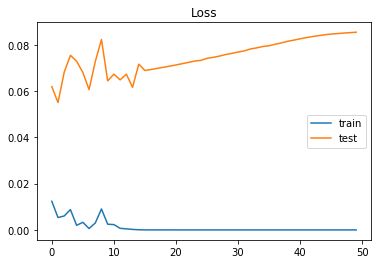

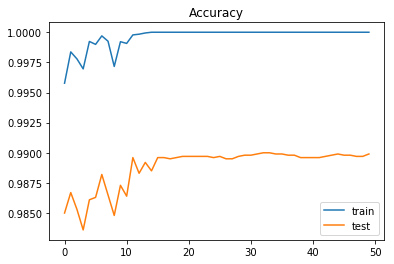

In [8]:
# Plot and save log figures
log = np.load(os.path.join(out, 'log.npz'))
bd.plot_util.plot_training_logs(log, out)

## 検証

In [9]:
val_model = net.CNV()
dummy_input = torch.Tensor(np.zeros((1, 1, 28, 28)).astype(np.float32))
val_model(dummy_input)
val_model.load_state_dict(torch.load(os.path.join(out, 'model.pt')))
val_model = val_model.eval()

evaluator = bd.Evaluator(val_model, 10, device=device)

Accuracy: 0.9899


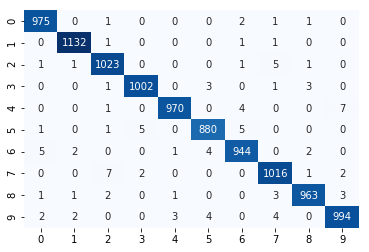

In [10]:
# Evaluation against clean dataset
ret = evaluator.run(
    test_dl,
    out=out,
    cmap='Blues',
    fmt='d',
    annot=True,
    cbar=False
)

Accuracy: 0.9900802496656264


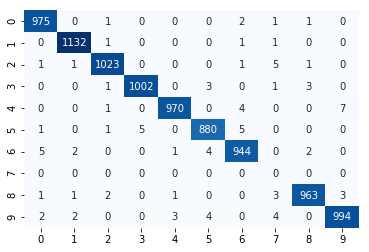

In [11]:
# Evaluation against poison dataset
ret = evaluator.run(
    test_p_dl,
    out=out,
    cmap='Blues',
    fmt='d',
    annot=True,
    cbar=False
)